In [1]:
# =============================================
#   CellMap nucleus-related segmentation (crop292 only)
#   Classes: 20,21,22,23,24,28
#   Author: Chenle Wang
#   TU Dresden - CMS Research Project
# =============================================

import os
import json
import numpy as np
import zarr
import matplotlib.pyplot as plt
from skimage.filters import gaussian, sobel, laplace
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score

In [2]:
# ---------------------------------------------
# Step 1. Setup paths
# ---------------------------------------------

RAW_S0 = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/em/fibsem-uint8/s0"
CROP292_ROOT = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/labels/groundtruth/crop292"

# 6 个核相关 atomic class
NUCLEUS_CLASSES = [
    "ne_mem",  # 20
    "ne_lum",  # 21
    "np_out",  # 22
    "np_in",  # 23
    "hchrom",  # 24
    "nucpl",  # 28
]

# multi-class 映射：背景=0
CLASS_ID_MAP = {
    "ne_mem": 1,
    "ne_lum": 2,
    "np_out": 3,
    "np_in": 4,
    "hchrom": 5,
    "nucpl": 6,
}

# 用 nucpl 做 reference（也可以自动选，这里简单固定）
REF_CLASS = "nucpl"
REF_S0 = os.path.join(CROP292_ROOT, REF_CLASS, "s0")
REF_ZATTR = os.path.join(CROP292_ROOT, REF_CLASS, ".zattrs")

raw_zarr = zarr.open(RAW_S0, mode="r")
ref_zarr = zarr.open(REF_S0, mode="r")

print("Raw shape:", raw_zarr.shape)
print("Reference label shape:", ref_zarr.shape)


Raw shape: (1813, 4368, 20609)
Reference label shape: (400, 400, 400)


In [3]:
# ---------------------------------------------
# Step 2. Read .zattrs (translation + scale)
# ---------------------------------------------

with open(REF_ZATTR, "r") as f:
    attrs = json.load(f)

ms = attrs["multiscales"][0]["datasets"][0]

scale = ms["coordinateTransformations"][0]["scale"]
trans = ms["coordinateTransformations"][1]["translation"]

scale_z, scale_y, scale_x = scale
tz, ty, tx = trans

print("Scale (nm):", scale)
print("Translation (nm):", trans)


Scale (nm): [2.0, 2.0, 2.0]
Translation (nm): [862.0, 5282.0, 6702.0]


In [4]:
# ---------------------------------------------
# Step 3. Convert nm → voxel index & crop raw
# ---------------------------------------------

vz0 = int(tz / scale_z)
vy0 = int(ty / scale_y)
vx0 = int(tx / scale_x)

Dz, Dy, Dx = ref_zarr.shape
vz1, vy1, vx1 = vz0 + Dz, vy0 + Dy, vx0 + Dx

print("Voxel coords:", (vz0, vz1), (vy0, vy1), (vx0, vx1))

raw_crop = raw_zarr[vz0:vz1, vy0:vy1, vx0:vx1]
print("Raw crop shape:", raw_crop.shape)

Voxel coords: (431, 831) (2641, 3041) (3351, 3751)
Raw crop shape: (400, 400, 400)



===== Loading 6-class nucleus labels =====
ne_mem  -> class 1, unique=[0 1]
ne_lum  -> class 2, unique=[0 1]
np_out  -> class 3, unique=[0 1]
np_in   -> class 4, unique=[0 1]
hchrom  -> class 5, unique=[0 1]
nucpl   -> class 6, unique=[0 1]
Unique final multi-class labels: [0 1 2 3 4 5 6]


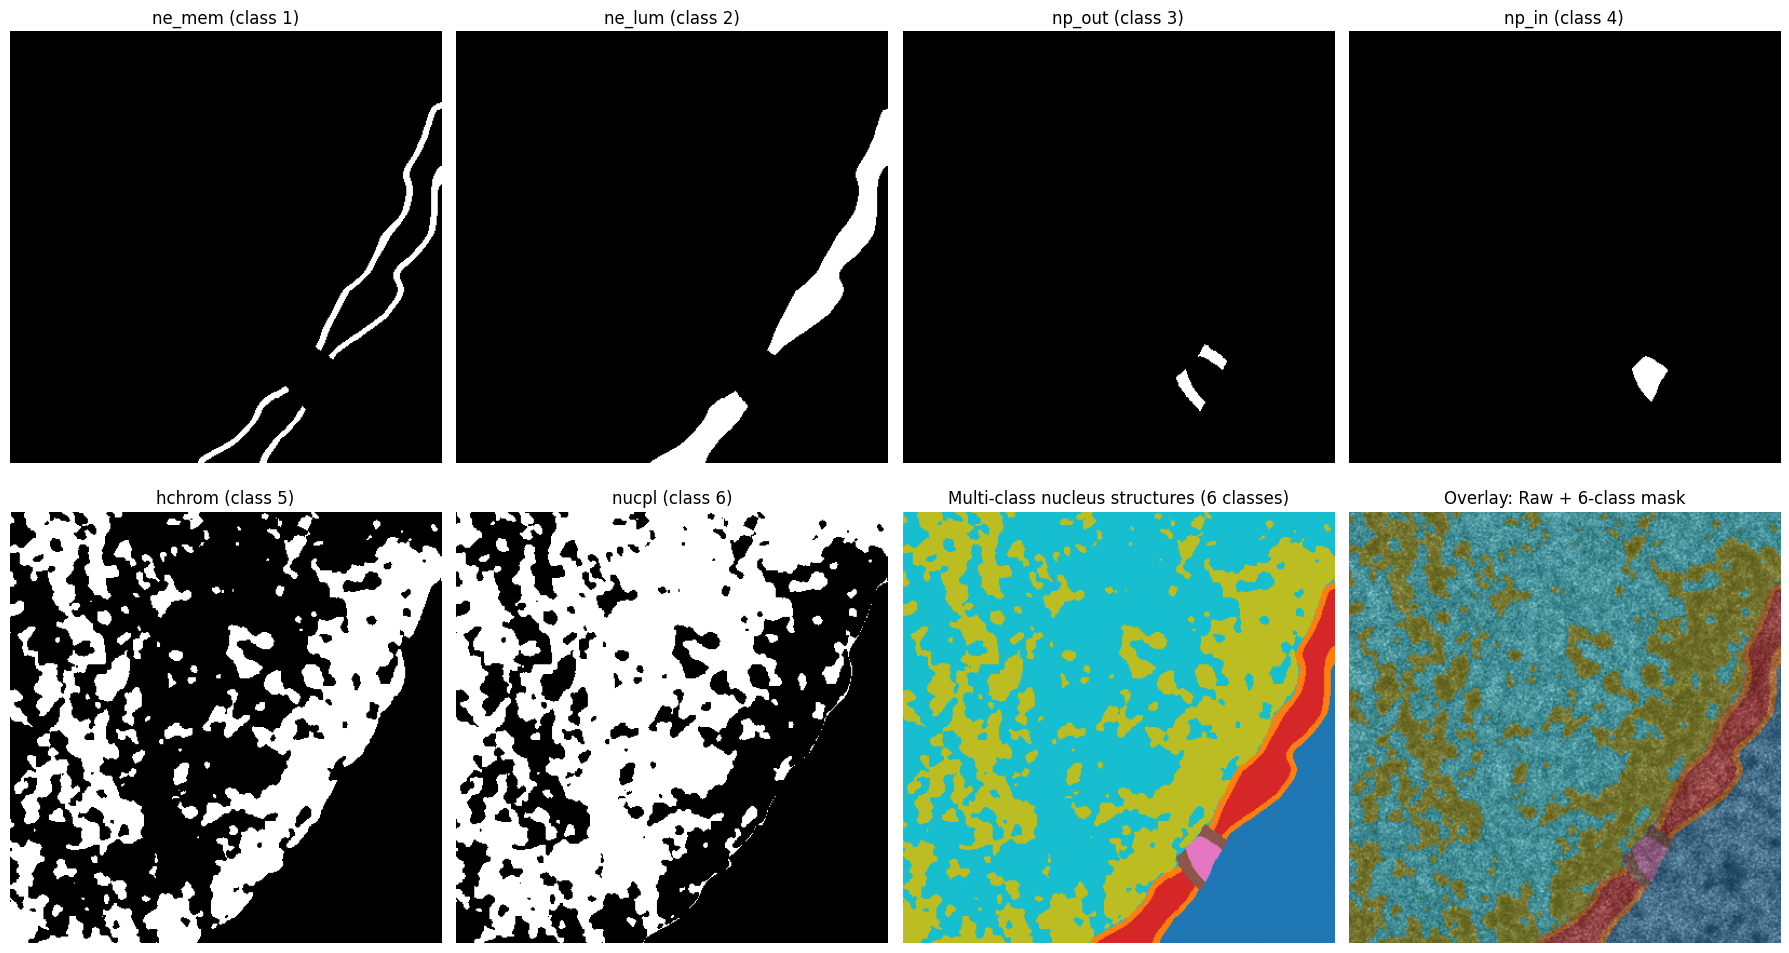

In [5]:
# ---------------------------------------------
# Step 4. Build multi-class label (0–6) + 可视化
# ---------------------------------------------

label_multi = np.zeros(ref_zarr.shape, dtype=np.uint8)

print("\n===== Loading 6-class nucleus labels =====")
for cname in NUCLEUS_CLASSES:
    path = os.path.join(CROP292_ROOT, cname, "s0")
    arr = zarr.open(path, mode="r")[:]
    cid = CLASS_ID_MAP[cname]
    print(f"{cname:7s} -> class {cid}, unique={np.unique(arr)}")
    label_multi[arr > 0] = cid

print("Unique final multi-class labels:", np.unique(label_multi))

# -------------------------------
# Step 4 Visualization (new)
# -------------------------------
mid = label_multi.shape[0] // 2 + 1
plt.figure(figsize=(18, 10))

# 逐类单独可视化
for i, cname in enumerate(NUCLEUS_CLASSES):
    cid = CLASS_ID_MAP[cname]
    mask = (label_multi[mid] == cid)

    plt.subplot(2, 4, i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(f"{cname} (class {cid})")
    plt.axis("off")

# 多类别总览图（彩色）
plt.subplot(2, 4, 7)
plt.imshow(label_multi[mid], cmap="tab10")
plt.title("Multi-class nucleus structures (6 classes)")
plt.axis("off")

# 叠加图（raw + label）
plt.subplot(2, 4, 8)
plt.imshow(raw_crop[mid], cmap='gray')
plt.imshow(label_multi[mid], cmap='tab10', alpha=0.45)
plt.title("Overlay: Raw + 6-class mask")
plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
# ============================================================
# Step 5 (Modified): 3D Feature Extraction
# 三维特征提取：对每个 z-slice 提取前后层的空间信息
# ============================================================
from scipy.ndimage import gaussian_filter, sobel, laplace
import numpy as np


def extract_3d_features(volume, z):
    """
    volume: 3D EM volume (Z,Y,X)
    z: target slice index

    return: (Y,X,C) 特征图 / feature map
    """

    Z, Y, X = volume.shape

    # ---------- 3D raw: 前一层 + 当前层 + 下一层 ----------
    z_prev = volume[z - 1] if z > 0 else volume[z]
    z_curr = volume[z]
    z_next = volume[z + 1] if z < Z - 1 else volume[z]
    raw_stack = np.stack([z_prev, z_curr, z_next], axis=-1)  # (Y,X,3)

    # ---------- Gaussian filter 3D ----------
    g1 = gaussian_filter(volume, sigma=1)[z]

    # # ---------- Sobel 3D (edge magnitude) ----------
    # sob_z = sobel(volume, axis=0)[z]
    # sob_y = sobel(volume, axis=1)[z]
    # sob_x = sobel(volume, axis=2)[z]
    # sob_mag = np.sqrt(sob_x ** 2 + sob_y ** 2 + sob_z ** 2)
    #
    # # ---------- Laplace 3D ----------
    # lap = laplace(volume)[z]

    # ---------- 合并所有特征 ----------
    feat = np.stack([
        raw_stack[..., 0],
        raw_stack[..., 1],
        raw_stack[..., 2],
        g1,
        # sob_mag,
        # lap
    ], axis=-1)  # (Y,X,C)

    return feat

In [35]:
# ============================================================
# Step 5.1: Build features for SELECTED z-slices only
# 为 n 个 z 层生成 3D 特征（快速实验模式）
# ============================================================

Z = raw_crop.shape[0]

# 均匀抽取 n 层
z_num = 30
selected_z = np.linspace(0, Z - 1, z_num, dtype=int)

print("Selected z-slices:", selected_z)

X_slices = []
y_slices = []

# 仅处理这 n 层
for z in selected_z:
    feat = extract_3d_features(raw_crop, z)  # (400,400,C)
    lab = label_multi[z]  # (400,400)

    X_slices.append(feat.reshape(-1, feat.shape[-1]))
    y_slices.append(lab.reshape(-1))


Selected z-slices: [  0  13  27  41  55  68  82  96 110 123 137 151 165 178 192 206 220 233
 247 261 275 288 302 316 330 343 357 371 385 399]


In [36]:
# # ============================================================
# # Step 5.1: Build features for ALL z-slices
# # 为所有 z-slices 生成 3D 特征
# # ============================================================
#
# Z = raw_crop.shape[0]
#
# X_slices = []   # 每层的特征矩阵 (160000, C)
# y_slices = []   # 每层的标签向量 (160000,)
#
# for z in range(Z):
#     feat = extract_3d_features(raw_crop, z)      # (400,400,C)
#     lab  = label_multi[z]                        # (400,400)
#
#     X_slices.append(feat.reshape(-1, feat.shape[-1]))
#     y_slices.append(lab.reshape(-1))


In [37]:
# ============================================================
# Step 6: K-fold Cross Validation (按 z 层划分)
# ============================================================

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []  # 记录每个 fold 的 IoU / Dice


In [ ]:
# ============================================================
# Step 7: Train & Validate (selected_z only) with tqdm progress bars
# ============================================================

from tqdm import tqdm

fold_scores = []

# 外层进度条：K-fold 进度
for fold, (train_idx, val_idx) in tqdm(
    enumerate(kf.split(range(len(selected_z)))),
    total=kf.n_splits,
    desc="K-Fold Progress"
):

    train_z = [selected_z[i] for i in train_idx]
    val_z   = [selected_z[i] for i in val_idx]

    print(f"\n================ FOLD {fold} ================")
    print("Train z slices:", train_z)
    print("Valid z slices:", val_z)

    # 内层进度条：单个 fold 的 4 个步骤
    fold_bar = tqdm(total=4, desc=f"Fold {fold} steps")

    # ============================================================
    # Step A: Build training set
    # ============================================================
    fold_bar.set_postfix_str("Building train set")
    X_train = np.concatenate([
        X_slices[selected_z.tolist().index(z)] for z in train_z
    ])
    y_train = np.concatenate([
        y_slices[selected_z.tolist().index(z)] for z in train_z
    ])
    fold_bar.update(1)

    # ============================================================
    # Step B: Build validation set
    # ============================================================
    fold_bar.set_postfix_str("Building val set")
    X_val = np.concatenate([
        X_slices[selected_z.tolist().index(z)] for z in val_z
    ])
    y_val = np.concatenate([
        y_slices[selected_z.tolist().index(z)] for z in val_z
    ])
    fold_bar.update(1)

    print("Train size:", X_train.shape)
    print("Val   size:", X_val.shape)

    # ============================================================
    # Step C: Train RandomForest
    # ============================================================
    fold_bar.set_postfix_str("Training RF")
    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=8,
        random_state=42
    )
    clf.fit(X_train, y_train)
    fold_bar.update(1)

    # ============================================================
    # Step D: Predict validation set
    # ============================================================
    fold_bar.set_postfix_str("Predicting")
    y_pred = clf.predict(X_val)
    fold_bar.update(1)

    fold_bar.close()

    # ============================================================
    # Step E: Compute metrics
    # ============================================================
    iou  = jaccard_score(y_val, y_pred, average="macro")
    dice = f1_score(y_val, y_pred, average="macro")

    print(f"FOLD {fold}  IoU={iou:.4f}  Dice={dice:.4f}")
    fold_scores.append((iou, dice))

# ============================================================
# Step 8: Print final results
# ============================================================
print("\n================ Final K-fold Results ================\n")

for k, (iou, dice) in enumerate(fold_scores):
    print(f"Fold {k}:   IoU={iou:.4f}   Dice={dice:.4f}")

avg_iou  = np.mean([s[0] for s in fold_scores])
avg_dice = np.mean([s[1] for s in fold_scores])

print("\nAverage IoU :", avg_iou)
print("Average Dice:", avg_dice)


In [38]:
# ============================================================
# Step 7: Train & Validate (selected_z only)
# ============================================================

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(selected_z)))):
    train_z = [selected_z[i] for i in train_idx]
    val_z = [selected_z[i] for i in val_idx]

    print(f"\n================ FOLD {fold} ================")
    print("Train z slices:", train_z)
    print("Valid z slices:", val_z)

    # 拼接训练数据
    X_train = np.concatenate([X_slices[selected_z.tolist().index(z)] for z in train_z])
    y_train = np.concatenate([y_slices[selected_z.tolist().index(z)] for z in train_z])

    # 拼接验证数据
    X_val = np.concatenate([X_slices[selected_z.tolist().index(z)] for z in val_z])
    y_val = np.concatenate([y_slices[selected_z.tolist().index(z)] for z in val_z])

    print("Train size:", X_train.shape)
    print("Val   size:", X_val.shape)

    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=8,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    iou = jaccard_score(y_val, y_pred, average="macro")
    dice = f1_score(y_val, y_pred, average="macro")

    print(f"FOLD {fold}  IoU={iou:.4f}  Dice={dice:.4f}")
    fold_scores.append((iou, dice))



================ FOLD 0 ================
Train z slices: [np.int64(0), np.int64(13), np.int64(27), np.int64(41), np.int64(55), np.int64(68), np.int64(82), np.int64(96), np.int64(137), np.int64(151), np.int64(165), np.int64(178), np.int64(192), np.int64(220), np.int64(247), np.int64(261), np.int64(275), np.int64(288), np.int64(302), np.int64(330), np.int64(343), np.int64(357), np.int64(385), np.int64(399)]
Valid z slices: [np.int64(110), np.int64(123), np.int64(206), np.int64(233), np.int64(316), np.int64(371)]
Train size: (3840000, 4)
Val   size: (960000, 4)
FOLD 0  IoU=0.1990  Dice=0.2532

================ FOLD 1 ================
Train z slices: [np.int64(13), np.int64(27), np.int64(41), np.int64(68), np.int64(82), np.int64(96), np.int64(110), np.int64(123), np.int64(137), np.int64(151), np.int64(178), np.int64(192), np.int64(206), np.int64(233), np.int64(247), np.int64(261), np.int64(275), np.int64(288), np.int64(302), np.int64(316), np.int64(343), np.int64(357), np.int64(371), np.i

In [24]:
# # ============================================================
# # Step 7: Train & Validate for Each Fold
# # 循环执行每个 fold 的训练与验证
# # ============================================================
#
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import jaccard_score, f1_score
#
# for fold, (train_z, val_z) in enumerate(kf.split(range(Z))):
#
#     print(f"\n================ FOLD {fold} ================")
#     print("Train z slices:", train_z[:10], "...")
#     print("Valid z slices:", val_z[:10], "...\n")
#
#     # ---------- 拼接所有训练层 ----------
#     X_train = np.concatenate([X_slices[z] for z in train_z], axis=0)
#     y_train = np.concatenate([y_slices[z] for z in train_z], axis=0)
#
#     # ---------- 拼接所有验证层 ----------
#     X_val = np.concatenate([X_slices[z] for z in val_z], axis=0)
#     y_val = np.concatenate([y_slices[z] for z in val_z], axis=0)
#
#     print("Train size:", X_train.shape, y_train.shape)
#     print("Val   size:", X_val.shape, y_val.shape)
#
#     # ---------- Train RandomForest ----------
#     clf = RandomForestClassifier(
#         n_estimators=200,
#         class_weight="balanced",
#         n_jobs=-1,
#         random_state=42
#     )
#
#     print("Training RF...")
#     clf.fit(X_train, y_train)
#
#     print("Predicting...")
#     y_pred = clf.predict(X_val)
#
#     # ---------- Evaluate ----------
#     iou  = jaccard_score(y_val, y_pred, average="macro")
#     dice = f1_score(y_val, y_pred, average="macro")
#
#     print(f"FOLD {fold}  IoU={iou:.4f}  Dice={dice:.4f}")
#
#     fold_scores.append((iou, dice))


In [25]:
# ============================================================
# Step 8: Print Final Results
# ============================================================

print("\n================ Final K-fold Results ================\n")

for k, (iou, dice) in enumerate(fold_scores):
    print(f"Fold {k}:   IoU={iou:.4f}   Dice={dice:.4f}")

avg_iou = np.mean([s[0] for s in fold_scores])
avg_dice = np.mean([s[1] for s in fold_scores])

print("\nAverage IoU :", avg_iou)
print("Average Dice:", avg_dice)



================ Final K-fold Results ================

Fold 0:   IoU=0.1890   Dice=0.2466
Fold 1:   IoU=0.1657   Dice=0.2317
Fold 2:   IoU=0.1967   Dice=0.2507
Fold 3:   IoU=0.2112   Dice=0.2566
Fold 4:   IoU=0.1984   Dice=0.2505

Average IoU : 0.1921901364119316
Average Dice: 0.2472358430836002


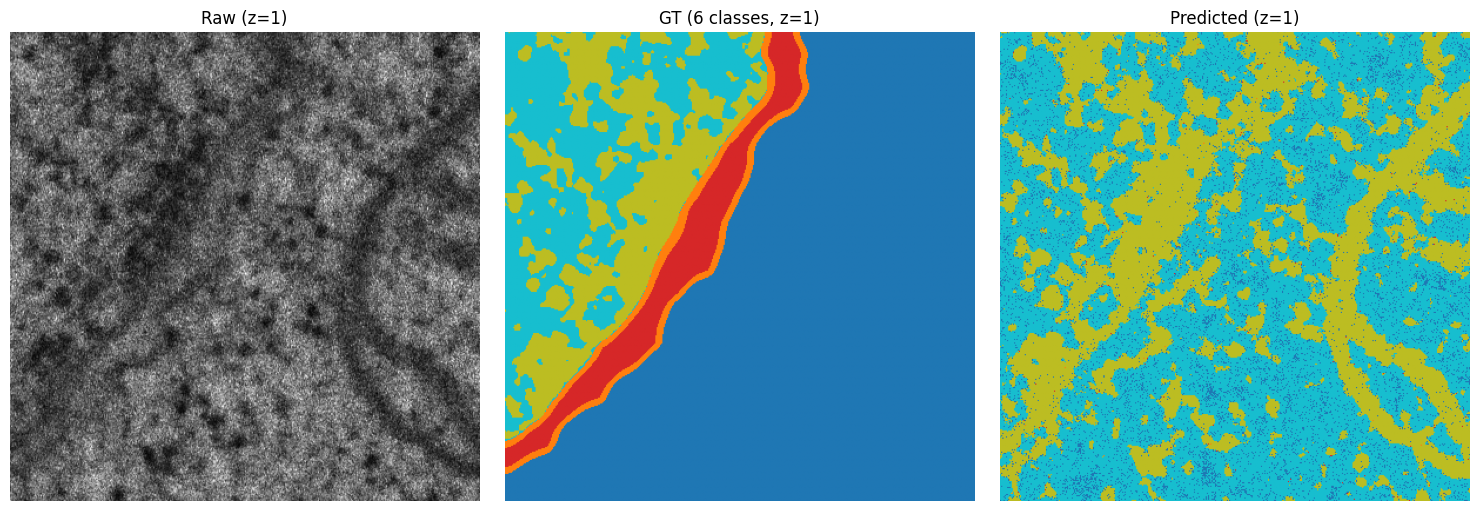

In [18]:
# ---------------------------------------------
# Test a specific z slice (predict + visualization)
# 测试某一层（z层）并可视化预测结果
# ---------------------------------------------

def test_one_slice(clf, raw_crop, label_multi, z):
    """
    测试单个 z-slice:
    - 提取 3D 特征
    - 调用 RF 做预测
    - 可视化 Raw / GT / Prediction
    """

    # ===== 1. 取该层的 raw + GT =====
    raw2d = raw_crop[z]
    label2d = label_multi[z]

    # ===== 2. 提取 3D 特征 =====
    feat = extract_3d_features(raw_crop, z)      # (400,400,C)
    X = feat.reshape(-1, feat.shape[-1])         # (160k, C)

    # ===== 3. RF 预测 =====
    y_pred_full = clf.predict(X).reshape(label2d.shape)

    # ===== 4. 可视化 =====
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(raw2d, cmap='gray')
    plt.title(f"Raw (z={z})")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(label2d, cmap='tab10')
    plt.title(f"GT (6 classes, z={z})")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(y_pred_full, cmap='tab10')
    plt.title(f"Predicted (z={z})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return y_pred_full

pred_image = test_one_slice(clf, raw_crop, label_multi, z=1)